# <span style="color:red"><center> Introduccion a Glove</center></span>

## <span style="color:blue">Modelos en Español</span>

El modelo GloVe significa Vectores Globales, que es un modelo de aprendizaje no supervisado que se puede utilizar para obtener vectores de palabras densas similares a Word2Vec. 

Sin embargo, la técnica es diferente y el entrenamiento se realiza en una matriz global de co-ocurrencia palabra-palabra, usando el contexto de las mismas, lo que nos da un espacio vectorial con subestructuras significativas. 

Este método fue inventado en Stanford por Pennington et al. y se recomienda que leer el artículo original sobre GloVe, [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf) de Pennington et al. que es una lectura excelente para tener una perspectiva de cómo funciona este modelo.



No cubriremos la implementación del modelo desde cero con demasiado detalle aquí, pero si está interesado en el código real, puede consultar la página oficial de [GloVe](https://nlp.stanford.edu/projects/glove/). 

Aquí mantendremos las cosas simples e intentaremos comprender los conceptos básicos detrás del modelo GloVe. Hemos hablado de métodos de factorización matricial basados en recuento como LSA y métodos predictivos como Word2Vec. 


El paper afirma que, actualmente, ambas familias sufren importantes inconvenientes. 


1. Los métodos como LSA aprovechan de manera eficiente la información estadística, pero funcionan relativamente mal en la tarea de analogía de palabras, como la forma en que descubrimos palabras semánticamente similares. 
2. Los métodos como skip-gram pueden funcionar mejor en la tarea de analogía, pero no utilizan tan bien las estadísticas del corpus a nivel global.


La metodología básica del modelo GloVe es crear primero una enorme matriz de co-ocurrencia palabra-contexto que consta de pares (palabra, contexto) de modo que cada elemento de esta matriz represente la frecuencia con la que aparece una palabra con el contexto (que puede ser una secuencia de palabras).

La idea entonces es aplicar factorización matricial para aproximar esta matriz como se muestra en la siguiente figura.

<figure>
<center>
<img src="../Imagenes/glove_matrix.png" width="400" height="300" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Base matemática  del modelo Glove</p>
</figcaption>
</figure>

Fuente: [understanding-feature-engineering](https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa)


Teniendo en cuenta la matriz **Word-Context (WC)**, la matriz **Word-Feature (WF)** y la **matriz Feature-Context (FC)**, intentamos factorizar **WC = WF x FC**, de modo que nuestro objetivo es reconstruir WC a partir de WF y FC multiplicando ellos. 


Para esto, normalmente inicializamos WF y FC con algunos pesos aleatorios e intentamos multiplicarlos para obtener WC ’(una aproximación de WC) y medir qué tan cerca está de WC. Hacemos esto varias veces usando el Descenso de gradiente estocástico (SGD) para minimizar el error. 

Finalmente, la matriz Word-Feature (WF) nos da las incrustaciones de palabras para cada palabra donde F se puede preestablecer para un número específico de dimensiones.

Un punto muy importante para recordar es que los modelos Word2Vec y GloVe son muy similares en su funcionamiento. 


Ambos tienen como objetivo construir un espacio vectorial donde la posición de cada palabra está influenciada por las palabras vecinas en función de su contexto y semántica. 

Word2Vec comienza con ejemplos individuales locales de pares de co-ocurrencia de palabras y GloVe comienza con estadísticas globales de co-ocurrencia agregadas en todas las palabras del corpus.

## <span style="color:blue">Introducción a spaCy</span>

Intentemos aprovechar las incrustaciones basadas en GloVe para nuestra tarea de agrupación de documentos. 

El marco de trabajo **spaCy** es muy popular y viene con capacidades para aprovechar las incrustaciones de GloVe basadas en diferentes modelos de lenguaje. 

También puede obtener vectores de palabras previamente entrenados y cargarlos según sea necesario usando gensim o spacy. 

Primero instalaremos spacy y usaremos el modelo **en_core_web_md** un modelo intermedio del inglés. Si desea resulatdos más potentes instale **en_vectors_web_lg** que consiste en vectores de palabras de 300 dimensiones entrenados en Common Crawl con GloVe, [GloVe](https://nlp.stanford.edu/projects/glove/). 


## <span style="color:blue">Modelos en Español</span>

En la página [spacy-models](https://spacy.io/usage/models) encuentra los modelos disponibles en *spacy*, basados en Glove, para distintos idioma. 

En particular para Español se tienen [modelos para Español en spacy](https://spacy.io/models/es) : 

1. es_core_news_sm (small): 15 MB
2. es_core_news_md (medium):  500k keys, 20k unique vectors (300 dimensions), 45 MB
3. es_core_news_lg (long): :  500k keys, 500k unique vectors (300 dimensions), 546 MB

Para bajar e instalar por ejemplo *es_core_news_md* puede escibir

*python -m spacy download es_core_news_md*

Veamos

In [15]:
!pip3 install spacy

In [16]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200

In [17]:
!python -m spacy download en_core_web_md 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 22.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [18]:
import spacy

nlp = spacy.load('en_core_web_md')


total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 20000


In [19]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


In [20]:
unique_words = list(set([word for sublist in [doc.split() for doc in corpus] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
dog.,-0.729170,0.419650,-0.208505,-0.344670,-0.029358,-0.100274,-0.075640,-0.112460,0.342230,1.817450,...,-0.142878,-0.078175,-0.428250,-0.050773,0.020879,0.614250,0.131848,-0.068726,-0.154206,0.133071
brown,-0.669060,-0.351330,0.080640,0.096664,-0.148040,-0.097573,0.243160,0.094992,0.582290,0.172680,...,0.412470,0.400660,-0.324850,-0.765130,-0.232630,-0.191630,0.230500,-0.637830,0.314030,0.203840
is,-0.600530,0.188380,-0.409930,0.322500,0.070322,0.161760,0.369450,-0.412770,-0.039160,2.228500,...,-0.307520,0.181140,0.021235,0.127830,0.352920,0.581560,0.362820,-0.277990,0.312290,-0.283310
"sausages,",-0.842805,0.079290,-0.013395,-0.127700,0.155020,0.615031,0.148265,-0.235432,-0.106760,1.702435,...,0.106775,0.014365,-0.710840,-0.065053,-0.253135,0.100140,0.045208,-0.545075,0.170844,-0.111019
I,-0.837120,-0.406320,-0.242020,-0.377190,0.005561,0.294150,-0.216470,-0.550520,-0.081881,1.594300,...,-0.064707,-0.491280,-0.314870,-0.409530,0.050129,0.019095,-0.216410,0.223610,-0.103160,0.540150
sky,-0.649850,-0.489260,-0.719320,-0.239570,-0.132790,-0.047248,-0.012852,0.314850,-0.129930,0.640200,...,-0.587860,-0.236660,-0.483780,0.246580,-0.110850,1.092000,0.031282,0.349100,0.770490,-0.326270
A,-0.600530,0.188380,-0.409930,0.322500,0.070322,0.161760,0.369450,-0.412770,-0.039160,2.228500,...,-0.307520,0.181140,0.021235,0.127830,0.352920,0.581560,0.362820,-0.277990,0.312290,-0.283310
The,-0.652760,0.238730,-0.233250,0.186080,0.376740,-0.054116,-0.191890,0.227310,-0.092528,1.838800,...,-0.285180,-0.077427,0.220630,-0.292880,-0.597510,-0.016613,-0.021909,-0.426360,0.485780,-0.289690
love,-0.610520,0.116560,-0.506480,-0.322160,-0.099742,0.101820,0.310420,-0.181550,0.317740,2.153700,...,0.173950,-0.014566,-0.286840,-0.416030,-0.010828,0.405140,-0.341460,0.103210,-0.088201,0.675430
but,-0.733510,0.413920,-0.442500,-0.291270,-0.096179,0.097562,0.131510,-0.518250,0.106710,2.414400,...,-0.304850,0.186480,-0.270480,-0.111110,0.126810,0.395380,-0.056084,-0.187770,-0.076822,-0.015507


/home/kainak0/gitProjects/mia/mia_302_pnl/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


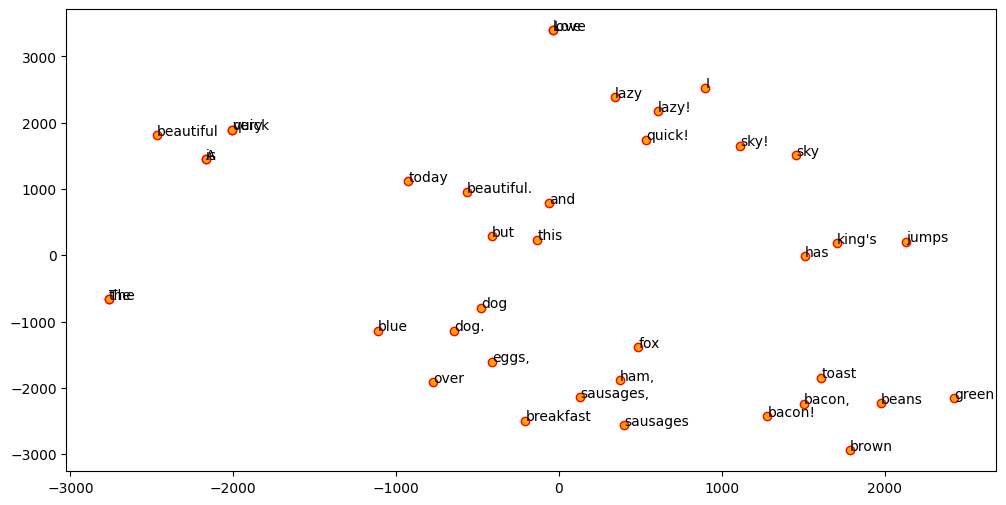

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [8]:
from sklearn.cluster import KMeans


doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in corpus])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,1
7,The dog is lazy but the brown fox is quick!,animals,1


/home/kainak0/gitProjects/mia/mia_302_pnl/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


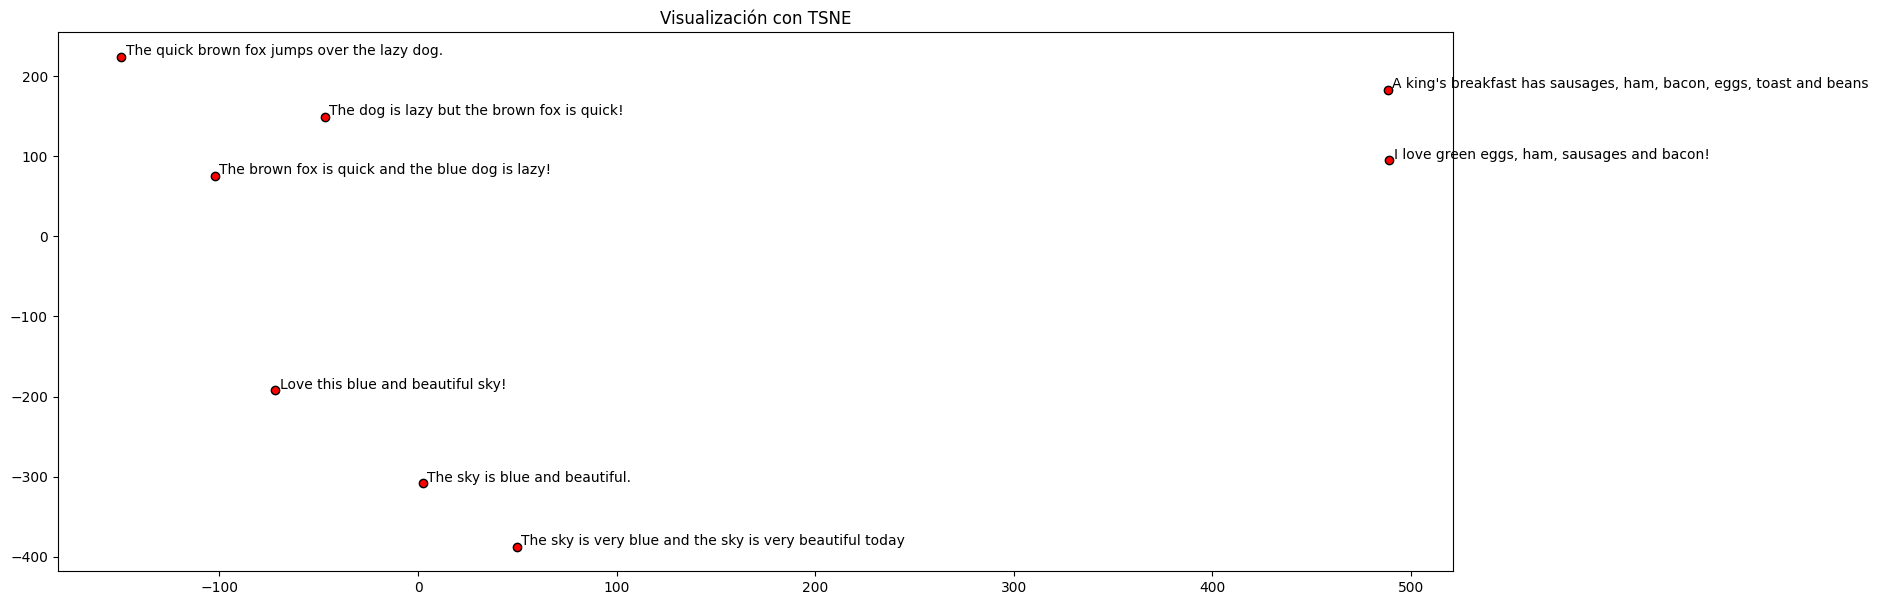

In [9]:
from sklearn.manifold import TSNE

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in corpus])

tsne = TSNE(n_components=2, random_state=200, n_iter=5000, perplexity=2,learning_rate='auto',init='pca')
P = tsne.fit_transform(doc_glove_vectors)
labels = corpus

plt.figure(figsize=(18, 7))
plt.scatter(P[:, 0], P[:, 1], c='r', edgecolors='k')
plt.title('Visualización con TSNE')

eps = 1e16*np.finfo(float).eps
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+eps, y+eps), xytext=(0, 0), textcoords='offset points')

In [10]:
from sklearn.cluster import AffinityPropagation

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in corpus])

ap = AffinityPropagation()
ap.fit(doc_glove_vectors)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)


,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,1
4,"I love green eggs, ham, sausages and bacon!",food,1
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beautiful today,weather,0
7,The dog is lazy but the brown fox is quick!,animals,2


In [11]:
feature_size = 300

In [12]:
def average_word_vectors(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    nwords = 0.
    
    for word in words:
        # Check if the word has a vector in spaCy
        if model.vocab.has_vector(word): 
            nwords += 1.
            feature_vector = np.add(feature_vector, model(word).vector)
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
def averaged_word_vectorizer(corpus, model, num_features):
    features = [average_word_vectors(tokenized_sentence, model, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)

# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=corpus, model=nlp, num_features=feature_size)

In [13]:
pp = pd.DataFrame(w2v_feature_array)
pp

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.738190,-0.010184,-0.142081,-0.095952,0.193396,0.053282,0.248972,-0.391964,0.046291,0.648518,...,0.241079,-0.070528,-0.225096,-0.076796,0.424990,-0.042846,0.088929,-0.076784,-0.299945,0.285269
1,-0.746911,-0.056842,-0.124898,-0.087352,0.210589,0.018436,0.285986,-0.369144,0.010622,0.547404,...,0.262494,-0.083345,-0.227410,-0.065653,0.463861,-0.067474,0.067018,-0.096896,-0.312952,0.321431
2,-0.739534,0.023778,-0.062667,-0.039704,0.249277,0.005667,0.188431,-0.344166,-0.055826,0.180448,...,0.330074,-0.044783,-0.180808,-0.144664,0.392415,-0.025655,-0.006162,-0.133693,-0.297828,0.240771
3,-0.692329,0.156360,-0.131446,0.054275,0.208128,0.069549,0.161914,-0.412658,0.028288,0.562219,...,0.266562,-0.016778,-0.115818,-0.061661,0.269455,0.125348,0.026418,-0.112083,-0.191210,0.117148
4,-0.739601,0.114056,-0.168516,-0.010981,0.205336,0.031320,0.170908,-0.411139,-0.072951,0.473631,...,0.273172,-0.072702,-0.113792,-0.111751,0.320113,0.060553,-0.014125,-0.156677,-0.245142,0.163227
5,-0.735342,-0.030145,-0.113038,-0.064529,0.234648,0.056254,0.177258,-0.378316,-0.040789,0.285020,...,0.287862,-0.058437,-0.171735,-0.131282,0.365596,-0.029815,0.021243,-0.094530,-0.299093,0.250612
6,-0.755954,-0.065920,-0.099765,-0.059304,0.207338,0.010042,0.265018,-0.270530,0.017334,0.554692,...,0.292605,-0.073155,-0.289356,-0.116608,0.509931,-0.074174,0.100992,-0.096868,-0.299951,0.318159
7,-0.727929,-0.026282,-0.079959,-0.063082,0.223761,0.065417,0.175005,-0.377915,-0.015717,0.207095,...,0.306098,-0.075223,-0.198272,-0.140574,0.369185,-0.053840,0.013246,-0.041918,-0.298714,0.281463


In [14]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,3
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,1
4,"I love green eggs, ham, sausages and bacon!",food,2
5,The brown fox is quick and the blue dog is lazy!,animals,3
6,The sky is very blue and the sky is very beautiful today,weather,0
7,The dog is lazy but the brown fox is quick!,animals,3
